<span style="font-size:42px"><b>Practise Case 04</b></span><br><br>
<span style="font-size:36px">Foundation of Machine Learning</span>

Copyright 2019 Gunawan Lumban Gaol

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language overning permissions and limitations under the License.

**Tasks**
1. Provide travel recommendation to passenger (best time to take a flight or best airline), so they will
not get caught in delay. Each recommendation has to be supported by at least 1 graph
2. Create a model to estimate the delay duration ( Linear Regression )
3. Create a model to predict delay > 60 min ( Logistic regression and another supervised model you
choosing )
4. Did you do some feature engineering on the dataset ? if yes, please give the reason for each
feature you created
5. Using those models predict delay that will happened in December for delay >60

# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from configparser import ConfigParser

from edapy.edapy import transformation
from edapy.edapy import plotting
from edapy.edapy import utils

In [2]:
config = ConfigParser()
config.read('./config.ini')

['./config.ini']

# Import Data

Dataset is a historical flight data in Malaysia from Oct 2018 – Nov 2018
Data consist of information of flight such as:
1. Date of flight
2. Date of arrival
3. Departure Delay
4. Tail Number
5. Airline Name
6. Departure Location
7. Arrival Location
8. Flight Number
9. Delay

In [3]:
data_train = pd.read_csv('csv/training_dataset.csv')
data_test = pd.read_csv('csv/test_dataset.csv')

In [4]:
print(data_train.shape)
print(data_test.shape)

(111068, 26)
(41557, 26)


In [5]:
data_train.head()

,id,number,airline,airline_name,scheduled_departure_time,scheduled_arrival_time,departure_airport_city,departure_airport_code,departure_airport_country,departure_airport_gate,...,arrival_airport_country,arrival_airport_gate,arrival_airport_name,arrival_airport_region,arrival_airport_terminal,arrival_airport_timezone,flight_equipment_iata,flight_equipment_name,flight_duration,delay
0,1,AK6430,AK,AirAsia,2018-10-05 22:00:00,2018-10-05 23:05:00,Kuala Lumpur,KUL,MY,J15,...,MY,2,Sultan Ismail Petra Airport,Asia,NaN,Asia/Kuala_Lumpur,32S,Airbus A318 / A319 / A320 / A321,58m,2
1,2,ID*7164,ID*,Batik Air,2018-10-05 22:00:00,2018-10-05 23:55:00,Kuala Lumpur,KUL,MY,C33,...,ID,5,Soekarno-Hatta International Airport,Asia,2,Asia/Jakarta,32S,Airbus A318 / A319 / A320 / A321,1h 55m,8
2,3,MXD9116,MXD,Malindo Air,2018-10-05 22:00:00,2018-10-05 23:55:00,Kuala Lumpur,KUL,MY,C33,...,ID,5,Soekarno-Hatta International Airport,Asia,2,Asia/Jakarta,32S,Airbus A318 / A319 / A320 / A321,1h 55m,8
3,4,AK5198,AK,AirAsia,2018-10-05 22:05:00,2018-10-06 01:00:00,Kuala Lumpur,KUL,MY,J9,...,MY,INT,Sandakan Airport,Asia,NaN,Asia/Kuala_Lumpur,32S,Airbus A318 / A319 / A320 / A321,2h 54m,0
4,5,AK516,AK,AirAsia,2018-10-05 22:10:00,2018-10-06 01:25:00,Kuala Lumpur,KUL,MY,P1,...,VN,NaN,Noi Bai International Airport,Asia,T2,Asia/Ho_Chi_Minh,32S,Airbus A318 / A319 / A320 / A321,3h 17m,0


See if all attributes in train dataset is present in the test datasets.

In [6]:
data_train.columns == data_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [7]:
data_train.columns

Index(['id', 'number', 'airline', 'airline_name', 'scheduled_departure_time',
       'scheduled_arrival_time', 'departure_airport_city',
       'departure_airport_code', 'departure_airport_country',
       'departure_airport_gate', 'departure_airport_name',
       'departure_airport_region', 'departure_airport_terminal',
       'departure_airport_timezone', 'arrival_airport_city',
       'arrival_airport_code', 'arrival_airport_country',
       'arrival_airport_gate', 'arrival_airport_name',
       'arrival_airport_region', 'arrival_airport_terminal',
       'arrival_airport_timezone', 'flight_equipment_iata',
       'flight_equipment_name', 'flight_duration', 'delay'],
      dtype='object')

# Data Cleansing

Inspect each column in the data, perform cleaning steps as required.
* Combine training and testing data for EDA purpose
* Convert column containing time to datetime dtype
* Convert numerical column stored as str dtype back to numerical dtype
* Drop column which has only 1 unique values

Before proceed, set 'col_id' and 'col_target' from the data.

In [8]:
col_ID = 'id'
col_target = 'delay'

## Data Combining

Combine the train and test dataset for EDA purpose.

In [9]:
data = pd.concat([data_train, data_test])

If 'col_id' is not unique, consider doing reset index on the dataframe or remove such duplicated data.

In [10]:
data = data.set_index(col_ID)

## Datetime Column

In [11]:
data['scheduled_departure_time'] = utils.lookup_date(data['scheduled_departure_time'])
data['scheduled_arrival_time'] = utils.lookup_date(data['scheduled_arrival_time'])

Use departure time for col_date.

In [12]:
col_date = 'scheduled_departure_time'

Add common datetime column features.

In [13]:
# Date
data['days']  = data[col_date].dt.strftime('%Y%m%d')
data['months'] = data[col_date].dt.strftime('%Y%m')
data['days_of_week'] = data[col_date].dt.day_name()
data['is_weekend'] = (data[col_date].dt.dayofweek >= 5).astype('int')

# Time
data['is_daytime'] = ((data[col_date].dt.hour >= 6) & (data[col_date].dt.hour < 18)).astype('int')

## String to Numerical Columns

Deal with attributes stored in string but actually is numerical.

In [14]:
temp = []
for duration in data['flight_duration'].str.split():
    try:
        if (len(duration) == 1):
            if (duration[0][-1] == 'm'):
                temp.append(int(duration[0][:-1]))
            else:
                temp.append(int(duration[0][:-1])*60)
        else:
            minutes = int(duration[0][:-1]) * 60 + int(duration[1][:-1])
            temp.append(minutes)
    except Exception as e: # null values
        temp.append(duration)

In [15]:
data['flight_duration'] = temp

## One Unique Value Column Data

Drop column which only has one unique value. Store in a dataframe. A column with one unique value may actually be the description of the whole data.

In [16]:
def get_one_unique(df):
    l = []
    for col in df.columns:
        if (df[col].nunique() == 1):
            l.append([col, df[col].unique()[0]])
    res = pd.DataFrame(l, columns=['attributes', 'values'])
    return res

In [17]:
df_one_unique = get_one_unique(data)
df_one_unique

,attributes,values
0,departure_airport_country,MY
1,departure_airport_region,Asia
2,departure_airport_timezone,Asia/Kuala_Lumpur


In [18]:
data = data.drop(df_one_unique['attributes'], axis=1)

# Data Preprocessing

Perform common preprocessing steps:
* Check missing & null data, remove them if necessary
* Check infinite values data, remove or convert to null if necessary
* Check duplicated data, remove them if necessary
* Split numerical and categorical column

## Infinite Values Data

In [19]:
data = data.replace([np.inf, -np.inf], np.nan)

## Duplicated Data

In [20]:
print("Total number of duplicated data: ", data.duplicated(subset=list(set(data.columns) - set(col_target))).sum())
print("In percentage: ", round(data.duplicated(subset=list(set(data.columns) - set(col_target))).sum()/data.shape[0]*100, 2), '%')

Total number of duplicated data:  11708
In percentage:  7.67 %


## Missing & Null Data

In [21]:
def get_missing(data):    
    missing_df = data.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['variable', 'missing values']
    missing_df['filling factor (%)'] = (data.shape[0] - missing_df['missing values'])/data.shape[0]*100
    missing_df = missing_df.sort_values('filling factor (%)').reset_index(drop = True)
    
    return missing_df

In [22]:
missing_df = get_missing(data)
missing_df

,variable,missing values,filling factor (%)
0,arrival_airport_gate,137275,10.057330
1,arrival_airport_terminal,79410,47.970516
2,departure_airport_gate,60619,60.282391
3,departure_airport_terminal,56588,62.923505
4,flight_equipment_name,22,99.985586
5,flight_equipment_iata,22,99.985586
6,scheduled_arrival_time,7,99.995414
7,flight_duration,5,99.996724
8,days_of_week,0,100.000000
9,months,0,100.000000


Some of columns that has at least 30% of missing values:
* `arrival_airport_terminal`
* `arrival_airpot_gate`
* `departure_airport_gate`
* `departure_airport_terminal`

Choose to delete these attributes for now, and explore later if there is enough time. 

In [23]:
data = data.drop(missing_df[missing_df['filling factor (%)'] < 70.0]['variable'], axis=1)

Drop rows with missing values.

In [24]:
def dropna(data):
    n_before = data.shape[0]
    data = data.dropna()
    n_after = data.shape[0]
    print("Dropped {:.2f}% of data".format((n_before-n_after)/n_before*100))
    return data

In [25]:
data = dropna(data)

Dropped 0.02% of data


## Split Numerical & Categorical Data

* Create numerical & categorical column list.

In [26]:
transformation.convert_to_categorical(data, 200)

Column airline casted to categorical
Column airline_name casted to categorical
Column departure_airport_city casted to categorical
Column departure_airport_code casted to categorical
Column departure_airport_name casted to categorical
Column arrival_airport_city casted to categorical
Column arrival_airport_code casted to categorical
Column arrival_airport_country casted to categorical
Column arrival_airport_name casted to categorical
Column arrival_airport_region casted to categorical
Column arrival_airport_timezone casted to categorical
Column flight_equipment_iata casted to categorical
Column flight_equipment_name casted to categorical
Column days casted to categorical
Column months casted to categorical
Column days_of_week casted to categorical
Column is_weekend casted to categorical
Column is_daytime casted to categorical


In [27]:
if (data[col_target].nunique() == 2):
    cols_num = list(set(data.select_dtypes(include=[np.number]).columns) - set([col_ID]))
    cols_cat = list(set(data.select_dtypes(exclude=[np.number]).columns) - set([col_target]))
else:
    cols_num = list(set(data.select_dtypes(include=[np.number]).columns) - set([col_ID, col_target]))
    cols_cat = list(set(data.select_dtypes(exclude=[np.number]).columns))

Filter `days` and `months` column.

In [28]:
cols_cat = list(set(cols_cat) - set(['days', 'months', 'scheduled_departure_time', 'scheduled_arrival_time']))

# Task 1: Travel Recommendation

This task gives recommendation on best flight or best time to avoid having delays. Before proceeding with the analysis, it is nice to know the reasons behind a flight delays. From [claimcompass.eu](https://www.claimcompass.eu/blog/why-is-my-flight-delayed/), we can see probable reasons behind a flight delays.

From 15 most common reasons listed there, it is worth a notice that a flight delays can be caused by a `knock-on effect`, in which when a flight is delayed because of the late arrival of an aircraft. This may alter the prediction (which will be done later) for flights which delays can't actually be predicted from the available attributes in the data. **For this analysis, it will now be assumed that all delays in the data is not caused by such effect.**

## Airline Recommendation

Rank the best airline based on its probability of a delay. Some notes to be keep in mind while doing the analysis:
* To accurately recommend the best airline based on its delay, we must make sure that the delay is not caused by external factor such as weather condition, bird migration, etc. as these factors are out of control of the airline.
* We must also consider the number of flights of each airlines, wouldn't trus too much on small airlines do we?
* Available flight destination. Does the airlines serves all routes?
* Available flight schedule. Does the airlines serves at all times during the day?

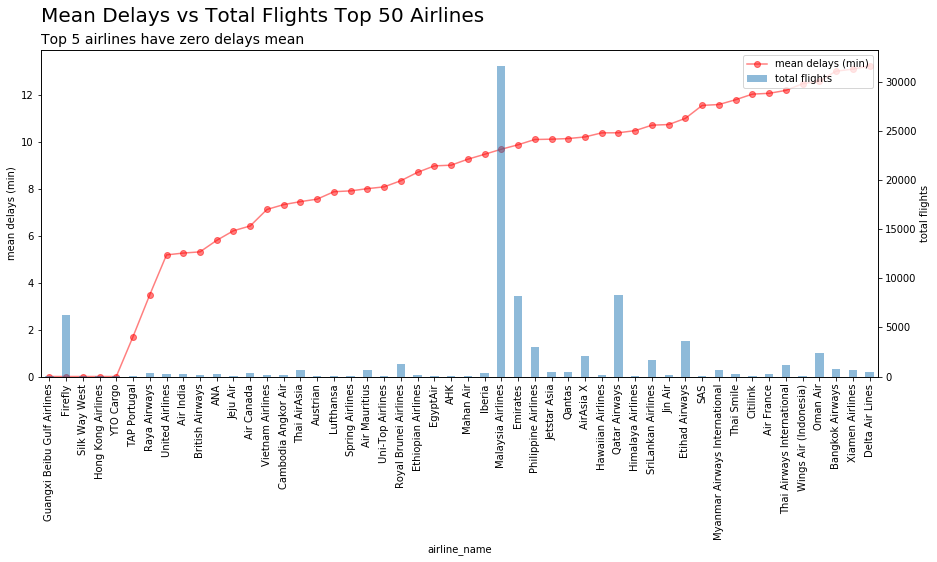

In [29]:
fig, ax = plt.subplots(figsize=(15, 6))
delays_mean = data.groupby('airline_name')[col_target].mean().sort_values()[:50]
delays_mean.plot(ax=ax, alpha=0.5, color='r', marker='o')
ax2 = ax.twinx()
data.groupby('airline_name')[col_target].count().reindex(delays_mean.index)[:50].plot.bar(ax=ax2, alpha=0.5, )
ax.set_ylim(0)
ax.set_ylabel('mean delays (min)')
ax2.set_ylabel('total flights')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, ['mean delays (min)', 'total flights'], loc=0)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
# plt.title(" \n", loc='left')
plt.suptitle('Mean Delays vs Total Flights Top 50 Airlines',fontsize=20, ha='left', x=0.125)
plt.title('Top 5 airlines have zero delays mean',fontsize=14, loc='left')
plt.show()

From figure above, there are 5 airlines with 0 delays mean, but only 1 out of those 5 airlines have a considerable amount of total flights. If decision is made here, we would choose `Firefly` as our recommended airline.

Next we will rank airlines based on the coverage of destination and times. The destination is from `arrival_airport_country` columns and the schedule coverage is from `scheduled_arrival_time`.

In [30]:
data['hours'] = data['scheduled_arrival_time'].dt.hour

Create pivot dataframe. Index of this dataframe will be sorted according to the delays_mean plot dataframe.

In [31]:
def create_pivot(data, x, y):
    g = data.groupby([y, x], as_index=False).size().reset_index(name='count')
    df = g.pivot(columns=x, index=y, values="count")
    df.fillna(0, inplace=True)
    df = df.reindex(delays_mean.index)[:5]
    df = df[::-1]
    return df

In [32]:
df_pivot_destination = create_pivot(data, 'arrival_airport_country', 'airline_name')
df_pivot_time = create_pivot(data, 'hours', 'airline_name')

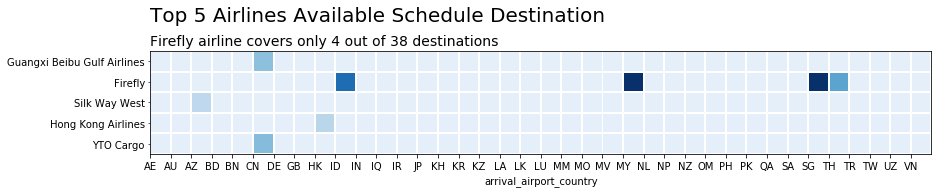

In [33]:
plotting.waffle_chart(df_pivot_destination, suptitle='Top 5 Airlines Available Schedule Destination', title='Firefly airline covers only 4 out of 38 destinations', figsize=(14, 2.8))

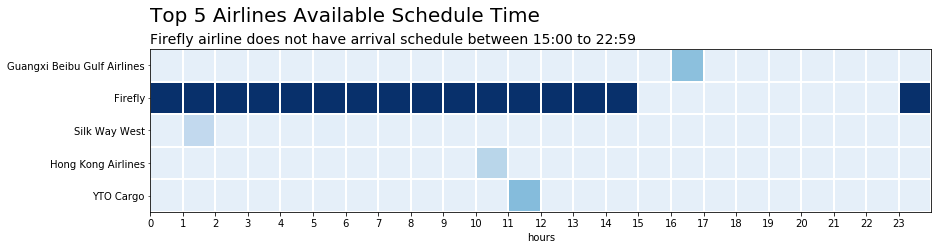

In [34]:
plotting.waffle_chart(df_pivot_time, suptitle='Top 5 Airlines Available Schedule Time', title='Firefly airline does not have arrival schedule between 15:00 to 22:59', figsize=(14, 3.6))

Based on the results from above 2 plots, we can recommend using `Firefly` only if we want to fly to 'ID', 'MY', 'SG', and 'TH' or if we want to arrive at the destination excluding 15:00 to 22:59.

We can explore further for domestic flights (in Malaysia) or combination of schedule and country, but we will skip that for now.

## Time Recommendation

Differing from previous sub task, in this task we must keep in mind only:

* The number of flights in each time interval which we will define.

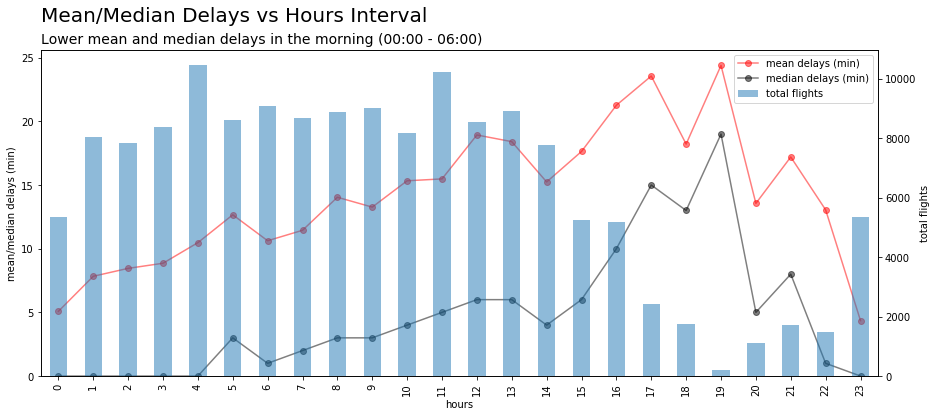

In [35]:
fig, ax = plt.subplots(figsize=(15, 6))
delays_mean = data.groupby('hours')[col_target].mean()
delays_mean.plot(ax=ax, alpha=0.5, color='r', marker='o')
data.groupby('hours')[col_target].median().plot(ax=ax, alpha=0.5, color='k', marker='o')
ax2 = ax.twinx()
data.groupby('hours')[col_target].count().reindex(delays_mean.index)[:50].plot.bar(ax=ax2, alpha=0.5, )
ax.set_ylim(0)
ax.set_ylabel('mean/median delays (min)')
ax2.set_ylabel('total flights')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, ['mean delays (min)', 'median delays (min)', 'total flights'], loc=0)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
# plt.title(" \n", loc='left')
plt.suptitle('Mean/Median Delays vs Hours Interval',fontsize=20, ha='left', x=0.125)
plt.title('Lower mean and median delays in the morning (00:00 - 06:00)',fontsize=14, loc='left')
plt.show()

Without looking at the airlines or destination, the best time to book a flight with **mininum delays is during dusktime, from 00:00 - 06:00.**

# Data Preparation

Preparation of train and test before modelling.

In [36]:
def prepare_data(df):
    data = df.copy()
    
    # Convert to datetime
    data['scheduled_departure_time'] = utils.lookup_date(data['scheduled_departure_time'])
    data['scheduled_arrival_time'] = utils.lookup_date(data['scheduled_arrival_time'])
    
    # Set col date
    col_date = 'scheduled_departure_time'
    
    # Date
    data['days']  = data[col_date].dt.strftime('%Y%m%d')
    data['months'] = data[col_date].dt.strftime('%Y%m')
    data['days_of_week'] = data[col_date].dt.day_name()
    data['is_weekend'] = (data[col_date].dt.dayofweek >= 5).astype('int')

    # Time
    data['is_daytime'] = ((data[col_date].dt.hour >= 6) & (data[col_date].dt.hour < 18)).astype('int')
    
    # Flight duration
    temp = []
    for duration in data['flight_duration'].str.split():
        try:
            if (len(duration) == 1):
                if (duration[0][-1] == 'm'):
                    temp.append(int(duration[0][:-1]))
                else:
                    temp.append(int(duration[0][:-1])*60)
            else:
                minutes = int(duration[0][:-1]) * 60 + int(duration[1][:-1])
                temp.append(minutes)
        except Exception as e: # null values
            temp.append(duration)
    data['flight_duration'] = temp
    
    # Drop one unique value column
    df_one_unique = get_one_unique(data)
    data = data.drop(df_one_unique['attributes'], axis=1)
    
    # Infinite values
    data = data.replace([np.inf, -np.inf], np.nan)
    
    # Missing & null data
    missing_df = get_missing(data)
    data = data.drop(missing_df[missing_df['filling factor (%)'] < 70.0]['variable'], axis=1)
    data = dropna(data)
    
    return data, df_one_unique, missing_df

In [37]:
data_train, df_one_unique_train, missing_df_train = prepare_data(data_train)
data_test, df_one_unique_test, missing_df_test = prepare_data(data_test)

Dropped 0.02% of data
Dropped 0.01% of data


## Feature Engineering

### `scheduled_flight_duration`

Get scheduled flight duration by subtracting arrival with departure time.

In [38]:
data_train['scheduled_departure_time'] = utils.lookup_date(data_train['scheduled_departure_time'])
data_train['scheduled_arrival_time'] = utils.lookup_date(data_train['scheduled_arrival_time'])

data_test['scheduled_departure_time'] = utils.lookup_date(data_test['scheduled_departure_time'])
data_test['scheduled_arrival_time'] = utils.lookup_date(data_test['scheduled_arrival_time'])

In [39]:
data_train['scheduled_flight_duration'] = [x.total_seconds() / 60 for x in (data_train['scheduled_arrival_time'] - data_train['scheduled_departure_time'])]
data_test['scheduled_flight_duration'] = [x.total_seconds() / 60 for x in (data_test['scheduled_arrival_time'] - data_test['scheduled_departure_time'])]

## Split Numerical & Categorical Data

In [40]:
if (data_train[col_target].nunique() == 2):
    cols_num = list(set(data_train.select_dtypes(include=[np.number]).columns) - set([col_ID]))
    cols_cat = list(set(data_train.select_dtypes(exclude=[np.number]).columns) - set([col_target]))
else:
    cols_num = list(set(data_train.select_dtypes(include=[np.number]).columns) - set([col_ID, col_target]))
    cols_cat = list(set(data_train.select_dtypes(exclude=[np.number]).columns))

In [41]:
cols_cat = list(set(cols_cat) - set(['days', 'months', 'scheduled_departure_time', 'scheduled_arrival_time']))

## Categorical Values Distribution

Check wether all unique values in all categorical columns present both in train and test dataset. If not, dropped the rows.

In [42]:
filt_idx_train = [True] * data_train.shape[0]
filt_idx_test = [True] * data_test.shape[0]
for col in cols_cat:
    if (sorted(data_train[col].unique()) != sorted(data_test[col].unique())):
        intersect = list(set(sorted(data_train[col].unique())) & set(sorted(data_test[col].unique())))
        filt_idx_train = filt_idx_train & data_train[col].isin(intersect)
        filt_idx_test = filt_idx_test & data_test[col].isin(intersect)

In [43]:
print(data_train.shape)
print(data_train[filt_idx_train].shape)

(111047, 25)
(106654, 25)


In [44]:
print(data_test.shape)
print(data_test[filt_idx_test].shape)

(41554, 24)
(40994, 24)


In [45]:
data_train = data_train[filt_idx_train]
data_test = data_test[filt_idx_test]

## Limit Categorical Columns

Filter out categorical columns with unique values more than 50.

In [46]:
to_drop = []
for col in cols_cat:
    if (data_train[col].nunique() > 50):
        to_drop.append(col)

In [47]:
cols_cat = list(set(cols_cat) - set(to_drop))

## Future Value Column

Drop the `flight_duration` column as it is information in the future when use in predicting.

In [51]:
cols_num.remove('flight_duration')

# Task 2: Model Estimating Delay Duration

Before doing linear regression, we must see if the assumption is true.

* Relation between dependant variable and independant variable is linear
* Error or residual of the model need to be normally distributed
* There is no multicollinearity

See the target attribute distribution between train and test dataset.

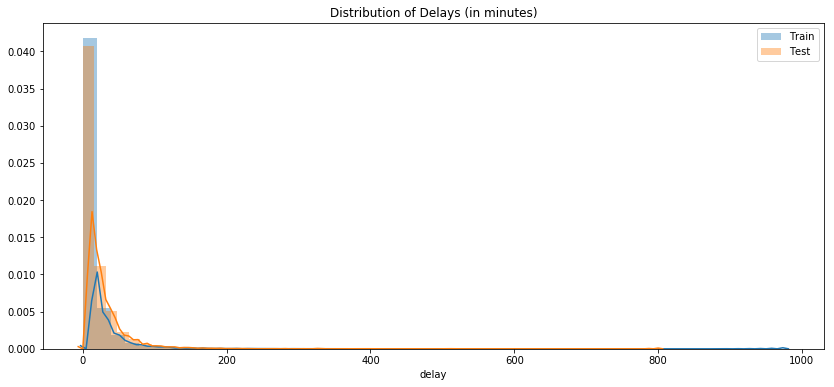

In [53]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.distplot(data_train[col_target], ax=ax)
sns.distplot(data_test[col_target], ax=ax)
ax.legend(['Train', 'Test'])
ax.set_title('Distribution of Delays (in minutes)')
plt.show()

See the difference in data date between train and test dataset.

In [54]:
print(min(data_train['scheduled_departure_time']), max(data_train['scheduled_departure_time']))
print(min(data_test['scheduled_departure_time']), max(data_test['scheduled_departure_time']))

2018-10-04 22:00:00 2018-11-30 23:55:00
2018-12-01 00:00:00 2018-12-20 15:59:00


The test dataset cotains data only twenty days from December month while the train dataset doesn't contain any time in December month. The distribution of target column is quite similar, so we can proceed.

## Linear Regression

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

In [56]:
for col in cols_cat:
    data_train = pd.concat([data_train, pd.get_dummies(data_train[col], prefix='d_'+col, drop_first=True)], axis=1)
    data_test = pd.concat([data_test, pd.get_dummies(data_test[col], prefix='d_'+col, drop_first=True)], axis=1)
cols_cat_d = data_train.columns[data_train.columns.str.startswith('d_')]
cols_feature = cols_num + list(cols_cat_d.values)

X_train = data_train[[c for c in cols_feature]]
y_train = data_train[col_target]
X_test = data_test[[c for c in cols_feature]]
y_test = data_test[col_target]

reg = LinearRegression()
reg.fit(X_train, y_train)

y_preds_train = reg.predict(X_train)
y_preds_test = reg.predict(X_test)

mse_train = mean_squared_error(y_train, y_preds_train)
mse_test = mean_squared_error(y_test, y_preds_test)

print(str.ljust("Train Mean Squared Error ", 25), str.rjust("{:3f}".format(mse_train), 20))
print(str.ljust("Test Mean Squared Error ", 25), str.rjust("{:3f}".format(mse_test), 20))
print()

Train Mean Squared Error            675.141355
Test Mean Squared Error             931.300174



In [57]:
r_square_train = r2_score(y_train, y_preds_train)
r_square_test = r2_score(y_test, y_preds_test)
print("Train R-square: {:.3f}".format(r_square_train))
print("Test R-square: {:.3f}".format(r_square_test))

Train R-square: 0.055
Test R-square: 0.018


In [58]:
result = sm.OLS(y_train, X_train).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  delay   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     61.74
Date:                Wed, 06 Nov 2019   Prob (F-statistic):               0.00
Time:                        14:06:56   Log-Likelihood:            -4.9876e+05
No. Observations:              106654   AIC:                         9.977e+05
Df Residuals:                  106553   BIC:                         9.987e+05
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
                                                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

# Task 3: Model Predict Delay > 60

Create new binomial target column.

In [59]:
data_train['delay_bin'] = (data_train['delay'] > 60.0).astype(int)
data_test['delay_bin'] = (data_test['delay'] > 60.0).astype(int)

## Logistic Regression

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, confusion_matrix, roc_auc_score, classification_report, roc_curve

def logistic_regression(X_train, X_test, y_train, y_test):
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)
    
    log_reg = LogisticRegression(solver='lbfgs')
    log_reg.fit(X_train, y_train)
    
    train_preds = log_reg.predict(X_train)
    test_preds = log_reg.predict(X_test)
    
    cm_train = confusion_matrix(y_train, train_preds)
    cm_test = confusion_matrix(y_test, test_preds)
    
    roc_auc_train = roc_auc_score(y_train, train_preds)
    roc_auc_test = roc_auc_score(y_test, test_preds)
    
    print(classification_report(y_train, train_preds))
    print()
    print(classification_report(y_test, test_preds))
    
    # ROC Curve
    y_train_sample_score = log_reg.decision_function(X_train)
    fpr_train, tpr_train, thresholds = roc_curve(y_train, y_train_sample_score)
    y_pred_sample_score = log_reg.decision_function(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_sample_score)

    roc_auc_train = auc(fpr_train, tpr_train)
    roc_auc = auc(fpr,tpr)

    # Plot ROC
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.title('Receiver Operating Characteristic')
    ax.plot(fpr_train, tpr_train, 'g', label='AUC_train = %0.3f'% roc_auc_train)
    ax.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
    ax.legend(loc='lower right')
    ax.plot([0,1],[0,1],'r--')
    ax.set_xlim([0,1.0])
    ax.set_ylim([0,1.01])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    plt.show()
    
    return cm_train, cm_test, roc_auc_train, roc_auc_test

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    102784
           1       0.56      0.00      0.01      3870

    accuracy                           0.96    106654
   macro avg       0.76      0.50      0.49    106654
weighted avg       0.95      0.96      0.95    106654


              precision    recall  f1-score   support

           0       0.94      1.00      0.97     38613
           1       0.60      0.00      0.00      2381

    accuracy                           0.94     40994
   macro avg       0.77      0.50      0.49     40994
weighted avg       0.92      0.94      0.91     40994



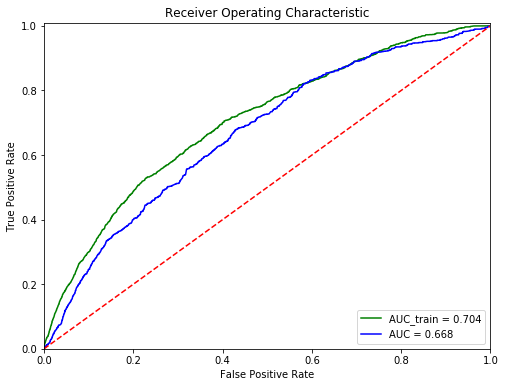

In [61]:
cm_train, cm_test, roc_auc_train, roc_auc_test = logistic_regression(X_train, X_test, data_train['delay_bin'], data_test['delay_bin'])

## Decision Tree

In [62]:
from sklearn.tree import DecisionTreeClassifier

def decision_tree(X_train, X_test, y_train, y_test):
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)
    
    log_reg = DecisionTreeClassifier(criterion='gini', 
                                     splitter='best', 
                                     max_depth=5, 
                                     min_samples_split=2, 
                                     min_samples_leaf=1,
                                     random_state=42)
    log_reg.fit(X_train, y_train)
    
    train_preds = log_reg.predict(X_train)
    test_preds = log_reg.predict(X_test)
    
    cm_train = confusion_matrix(y_train, train_preds)
    cm_test = confusion_matrix(y_test, test_preds)
    
    roc_auc_train = roc_auc_score(y_train, train_preds)
    roc_auc_test = roc_auc_score(y_test, test_preds)
    
    print(classification_report(y_train, train_preds))
    print()
    print(classification_report(y_test, test_preds))
    
    # ROC Curve
    y_train_sample_score = log_reg.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, thresholds = roc_curve(y_train, y_train_sample_score)
    y_pred_sample_score = log_reg.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_sample_score)

    roc_auc_train = auc(fpr_train, tpr_train)
    roc_auc = auc(fpr,tpr)

    # Plot ROC
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.title('Receiver Operating Characteristic')
    ax.plot(fpr_train, tpr_train, 'g', label='AUC_train = %0.3f'% roc_auc_train)
    ax.plot(fpr, tpr, 'b',label='AUC_test = %0.3f'% roc_auc)
    ax.legend(loc='lower right')
    ax.plot([0,1],[0,1],'r--')
    ax.set_xlim([0,1.0])
    ax.set_ylim([0,1.01])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    plt.show()
    
    return train_preds, test_preds

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    102784
           1       0.76      0.00      0.01      3870

    accuracy                           0.96    106654
   macro avg       0.86      0.50      0.49    106654
weighted avg       0.96      0.96      0.95    106654


              precision    recall  f1-score   support

           0       0.94      1.00      0.97     38613
           1       0.00      0.00      0.00      2381

    accuracy                           0.94     40994
   macro avg       0.47      0.50      0.49     40994
weighted avg       0.89      0.94      0.91     40994



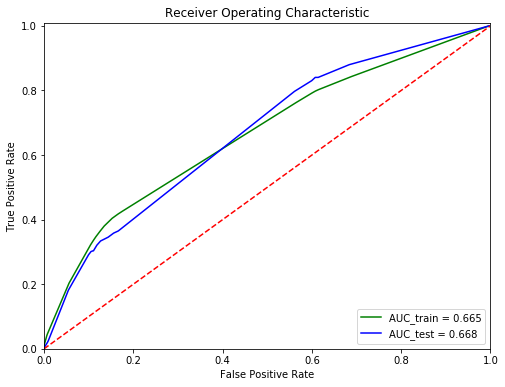

In [63]:
y_preds_train, y_preds_test = decision_tree(X_train, X_test, data_train['delay_bin'], data_test['delay_bin'])

# Task 4: Feature Engineering Reasoning

1. days_of_week, is_weekend: different traffic during weekend/not weekend, more granular in days
2. is_daytime: different weather condition during daytime and nighttime
3. flight_duration: dropping the column as it is future value
4. scheduled_flight_duration: perhaps longer flight duration require more preparation and more possible factor that can cause delay

# Task 5: Predict Delay that will Happened in December for Delay > 60

Turns out that all test data is in December. So we will try to predict 'Delay > 60' using test data.

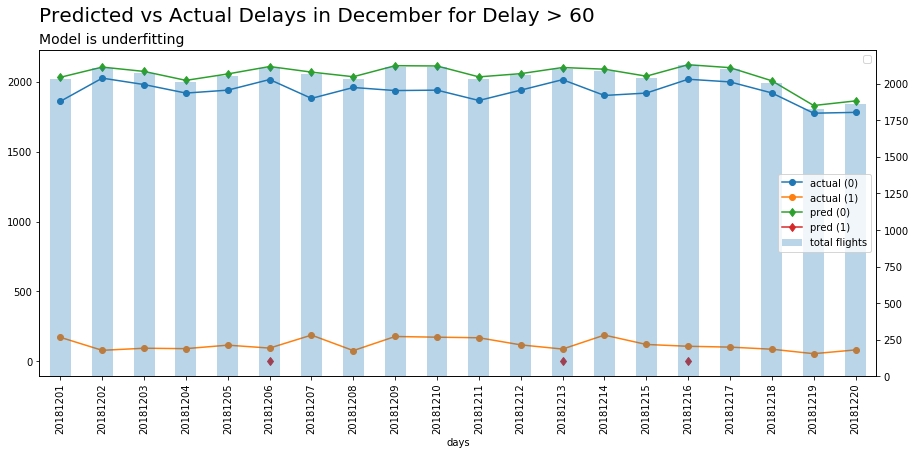

In [64]:
fig, ax = plt.subplots(figsize=(15, 6))
data_test.groupby(['days'])['delay_bin'].value_counts().unstack(1).plot(ax=ax, marker='o', alpha=1)
data_test['delay_bin_pred'] = y_preds_test
data_test.groupby(['days'])['delay_bin_pred'].value_counts().unstack(1).plot(ax=ax, marker='d', alpha=1)
ax2 = ax.twinx()
data_test.groupby(['days'])[col_target].count().plot.bar(ax=ax2, alpha=0.3)
ax.legend([])
# ax.set_ylim(0)
# ax.set_ylabel('mean delays (min)')
# ax2.set_ylabel('total flights')
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, ['actual (0)', 'actual (1)', 'pred (0)', 'pred (1)', 'total flights'], loc='center right')
plt.suptitle('Predicted vs Actual Delays in December for Delay > 60',fontsize=20, ha='left', x=0.125)
plt.title('Model is underfitting',fontsize=14, loc='left')
plt.show()

The model is very conservative, only detect delays in 4 days during December. Model is clearly underfitting.